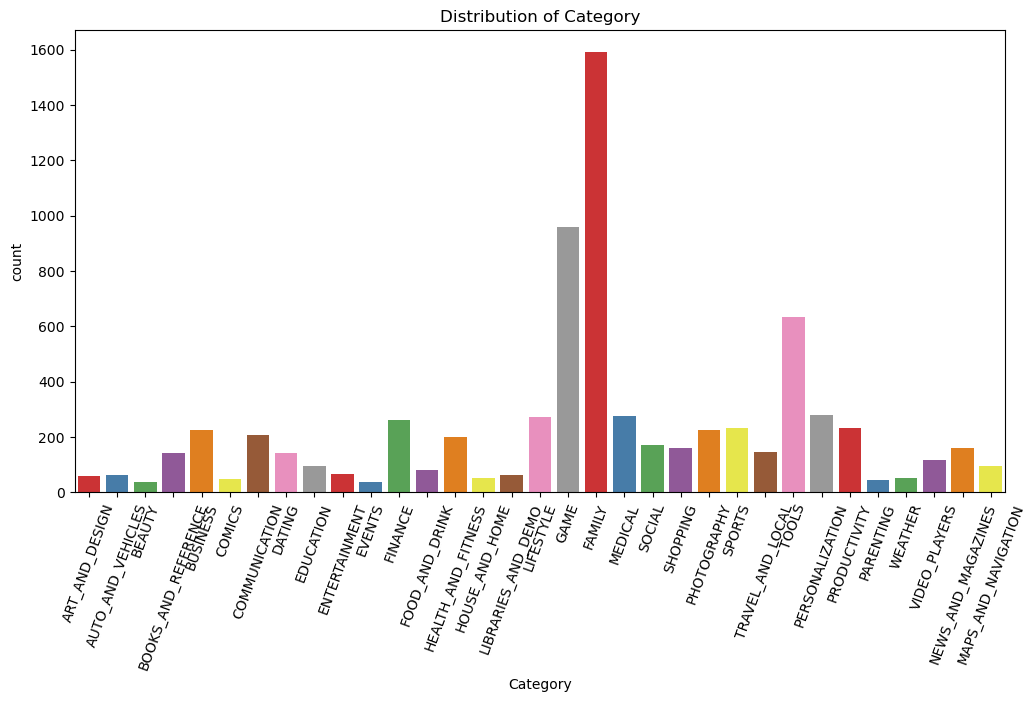

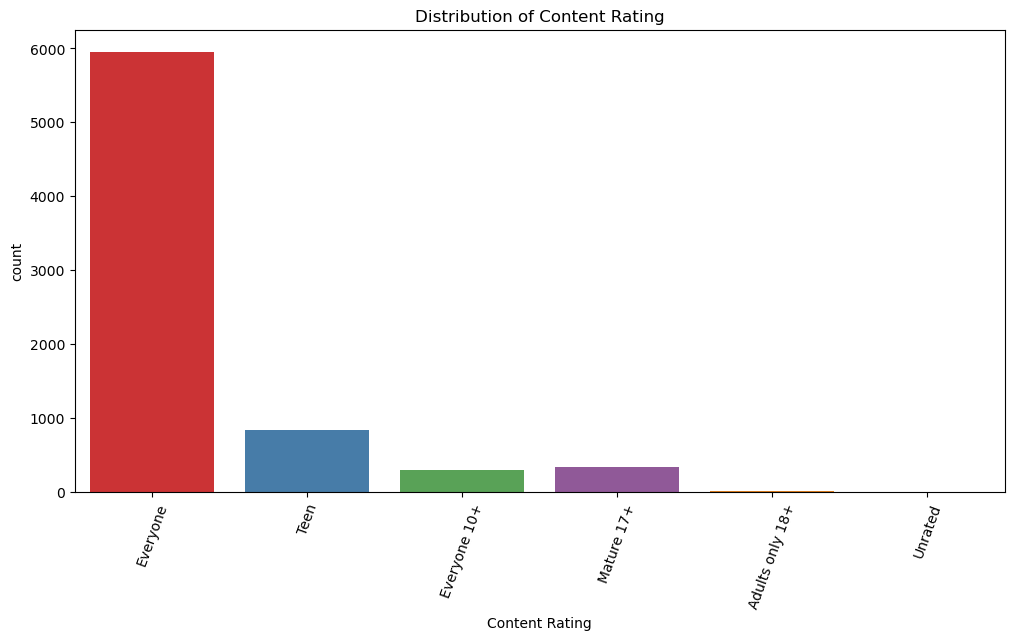

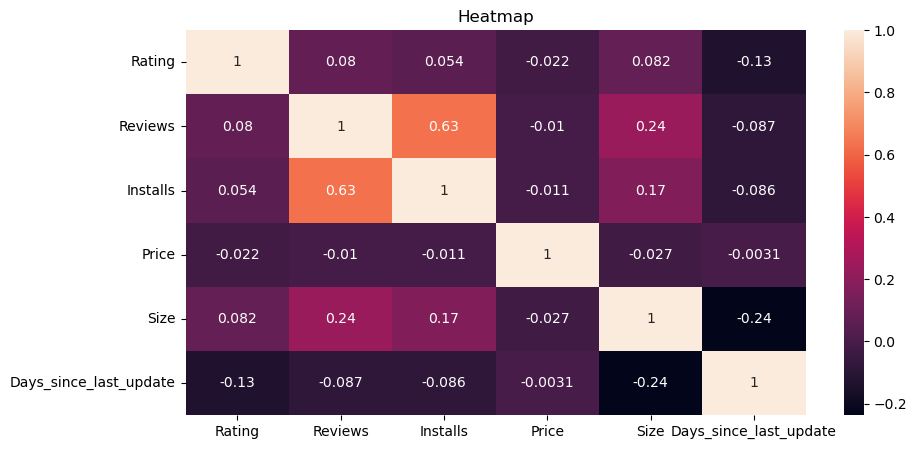

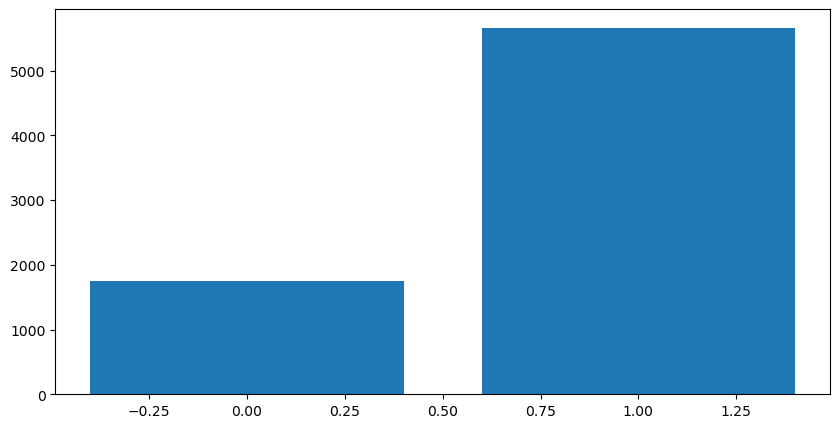

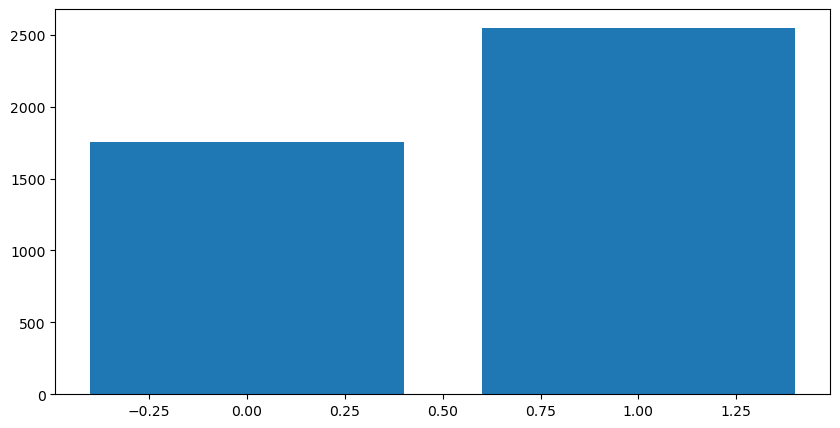

47
   Rating  Price  Reviews  Size  Installs  Days_since_last_update
0     3.9    0.0      967  14.0    500000                     205
1     3.8    0.0      178  19.0     50000                     104
2     3.2    0.0       55   2.7      5000                      63
3     3.9    0.0      136   4.6     10000                      27
4     3.8    0.0      564   9.2    100000                      28


In [66]:
%run ./Project_setup.ipynb
%run ./Metrics.py

## Classification with outlier detection

### Split dataset

In [67]:
features=data_db.drop(['Rating', 'Rating Interval'],axis=1)
label=data_db['Rating Interval']
standardized_features= Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
#smote = SMOTE()
# Fit and apply SMOTE
#train_X, train_Y = smote.fit_resample(train_X, train_Y)

## XGBoost

In [68]:
def objective(trial):
    """
    #首先使用params传递模型参数, 选定Xgboost模型后
    使用 3-fold cross validation与optuna优化器得到最优参数
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'booster':trial.suggest_categorical('booster',['gbtree']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),}
    model = XGBClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
clf_XGB= XGBClassifier(**best_params)
clf_XGB=clf_XGB.fit(train_X, train_Y)
y_pred_XGB=clf_XGB.predict(test_X)
#accuracy=accuracy_score(test_Y,y_pred_XGB)
#print("Accuracy of XGBoost: ",accuracy)

[I 2024-12-14 17:43:37,805] A new study created in memory with name: no-name-636032a5-bd80-4faf-ba8f-1a902af801b9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-14 17:43:38,451] Trial 0 finished with value: 0.5900445661991682 and parameters: {'n_estimators': 66, 'max_depth': 2, 'booster': 'gbtree', 'learning_rate': 0.0024676768765952584}. Best is trial 0 with value: 0.5900445661991682.
[I 2024-12-14 17:43:40,617] Trial 1 finished with value: 0.6252730382766413 and parameters: {'n_estimators': 101, 'max_depth': 18, 'booster': 'gbtree', 'learning_rate': 0.058542687674049146}. Best is trial 1 with value: 0.6252730382766413.
[I 2024-12-14 17:43:42,201] Trial 2 finished with value: 0.6027285630626606 and parameters: {'n_estimators': 169, 'max_depth': 6, 'booster': 'gbtree', 'learning_rate': 0.0039814187141669405}. Best is trial 1 with value: 0.6252730382766413.
[I 2024-12-14 17:43:44,705] Trial 3 finished with value: 0.6205770446025932 and parameters: {'n_estimators': 126, 'max_depth': 13, 'booster': 'gbtree', 'learning_rate': 0.009334472195632744}. Best is trial 1 with value: 0.6252730382766413.
[I 2024-12-14 17:43:46,618] Trial 4 finis

In [69]:
importances = clf_XGB.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        0.072748
 2) Category_PERSONALIZATION       0.045462
 3) Installs                       0.040125
 4) Category_DATING                0.032438
 5) Category_TRAVEL_AND_LOCAL      0.032284
 6) Category_HOUSE_AND_HOME        0.031856
 7) Category_LIFESTYLE             0.027688
 8) Category_HEALTH_AND_FITNESS    0.027558
 9) Category_NEWS_AND_MAGAZINES    0.026560
10) Genres_Education               0.025054
11) Genres_Casual                  0.024299
12) Price                          0.024132
13) Category_EVENTS                0.024109
14) Category_BUSINESS              0.024014
15) Content Rating_Everyone        0.023817
16) Content Rating_Everyone 10+    0.021187
17) Category_FINANCE               0.021102
18) Category_BOOKS_AND_REFERENCE   0.021036
19) Category_MAPS_AND_NAVIGATION   0.021017
20) Genres_Art & Design            0.020456
21) Category_EDUCATION             0.020423
22) Category_TOOLS                 0.019400
23) Days_since_last_update      

Accuracy: 0.6866197183098591
Precision: 0.6833160233869237
Recall: 0.6866197183098591
F1 Score: 0.6841600639753622


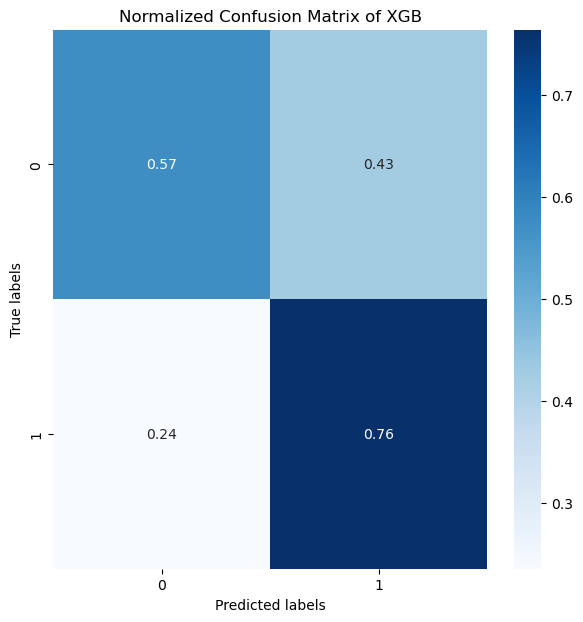

In [70]:
cm(test_X,test_Y,clf_XGB,'XGB',['0','1'])
#ROC(train_Y,test_Y,test_X,clf_XGB,'XGB')

#### Shap values for each Rating Interval

## Lightgbm


In [71]:
def objective(trial):
    params= {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred_lgbm=clf_lgbm.predict(test_X)
#accuracy=accuracy_score(test_Y,y_pred_lgbm)
#accuracy

[I 2024-12-14 17:48:43,213] A new study created in memory with name: no-name-40d4b7f3-d2e6-4f28-9ff6-3e528bfcba8c


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5839097706085216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5839097706085216
[LightGBM] [Warning] bagging_fraction is set=0.9351742473160972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9351742473160972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5839097706085216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5839097706085216
[LightGBM] [Warning] bagging_fraction is set=0.9351742473160972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9351742473160972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 2513, number of negative: 1746
[LightGBM] [Info] Auto-choosing c

#### Shap values for each Rating Interval

In [72]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        467.000000
 2) Days_since_last_update         314.000000
 3) Installs                       221.000000
 4) Size                           145.000000
 5) Price                          8.000000
 6) Content Rating_Everyone        7.000000
 7) Category_TOOLS                 7.000000
 8) Type_Free                      1.000000
 9) Genres_Arcade                  0.000000
10) Genres_Auto & Vehicles         0.000000
11) Genres_Art & Design;Pretend Play 0.000000
12) Genres_Art & Design;Creativity 0.000000
13) Genres_Art & Design            0.000000
14) Genres_Arcade;Pretend Play     0.000000
15) Genres_Arcade;Action & Adventure 0.000000
16) Genres_Adventure;Action & Adventure 0.000000
17) Genres_Adventure;Education     0.000000
18) Genres_Adventure;Brain Games   0.000000
19) Genres_Board                   0.000000
20) Genres_Adventure               0.000000
21) Genres_Action;Action & Adventure 0.000000
22) Genres_Action                  0.000000
23) Genres_Be

[LightGBM] [Warning] feature_fraction is set=0.9445169216269114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445169216269114
[LightGBM] [Warning] bagging_fraction is set=0.3615747183966005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3615747183966005
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Accuracy: 0.6596244131455399
Precision: 0.6542029226244508
Recall: 0.6596244131455399
F1 Score: 0.6549566643218835


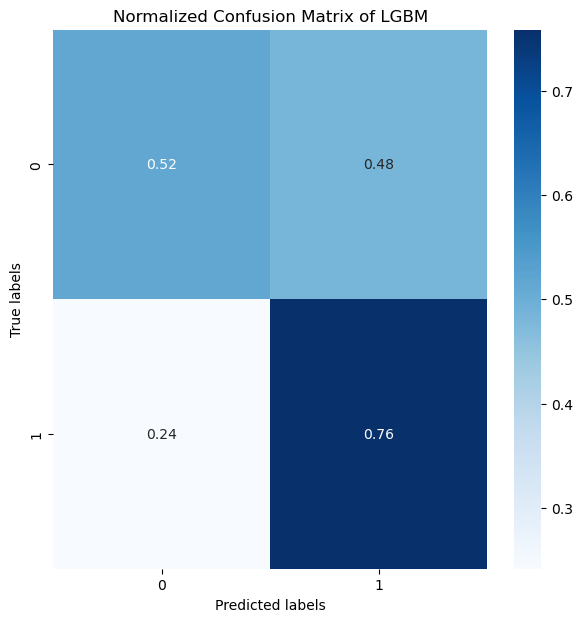

ValueError: Found input variables with inconsistent numbers of samples: [852, 1704]

In [73]:
cm(test_X,test_Y,clf_lgbm,'LGBM',['0','1'])
ROC(train_Y,test_Y,test_X,clf_XGB,'LGBM')

## Catboost

In [74]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'task_type':trial.suggest_categorical('task_type',['GPU']),
        'loss_function':trial.suggest_categorical('loss_function',['MultiClass'])
    }
    model = cat.CatBoostClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_cat= cat.CatBoostClassifier(**best_params)
clf_cat.fit(train_X, train_Y)
y_pred_cat=clf_cat.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_cat)
accuracy

[I 2024-12-14 17:49:53,870] A new study created in memory with name: no-name-c23314a3-ede5-499f-84f2-41e1998b92f6


  0%|          | 0/50 [00:00<?, ?it/s]

0:	learn: 0.6883466	total: 3.19ms	remaining: 304ms
1:	learn: 0.6840169	total: 5.16ms	remaining: 243ms
2:	learn: 0.6799578	total: 7.13ms	remaining: 221ms
3:	learn: 0.6761838	total: 9.13ms	remaining: 210ms
4:	learn: 0.6726133	total: 11.2ms	remaining: 204ms
5:	learn: 0.6690175	total: 13.3ms	remaining: 199ms
6:	learn: 0.6657489	total: 15.3ms	remaining: 195ms
7:	learn: 0.6627419	total: 18.2ms	remaining: 200ms
8:	learn: 0.6598809	total: 20.1ms	remaining: 195ms
9:	learn: 0.6571344	total: 22.2ms	remaining: 191ms
10:	learn: 0.6544526	total: 24ms	remaining: 186ms
11:	learn: 0.6521246	total: 25.8ms	remaining: 181ms
12:	learn: 0.6496347	total: 27.7ms	remaining: 177ms
13:	learn: 0.6475008	total: 29.6ms	remaining: 173ms
14:	learn: 0.6452711	total: 31.7ms	remaining: 171ms
15:	learn: 0.6433195	total: 33.6ms	remaining: 168ms
16:	learn: 0.6414879	total: 35.6ms	remaining: 166ms
17:	learn: 0.6396085	total: 37.5ms	remaining: 163ms
18:	learn: 0.6377501	total: 39.7ms	remaining: 161ms
19:	learn: 0.6361475	tot

0.6525821596244131

In [75]:
importances = clf_cat.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        66.629533
 2) Installs                       18.950448
 3) Days_since_last_update         7.820595
 4) Category_PERSONALIZATION       2.915850
 5) Price                          2.450654
 6) Genres_Personalization         0.916115
 7) Type_Free                      0.316805
 8) Category_AUTO_AND_VEHICLES     0.000000
 9) Content Rating_Teen            0.000000
10) Genres_Board                   0.000000
11) Genres_Beauty                  0.000000
12) Genres_Auto & Vehicles         0.000000
13) Genres_Art & Design;Pretend Play 0.000000
14) Genres_Art & Design;Creativity 0.000000
15) Genres_Art & Design            0.000000
16) Genres_Arcade;Pretend Play     0.000000
17) Genres_Arcade;Action & Adventure 0.000000
18) Genres_Arcade                  0.000000
19) Genres_Adventure;Education     0.000000
20) Genres_Adventure;Brain Games   0.000000
21) Genres_Adventure;Action & Adventure 0.000000
22) Genres_Adventure               0.000000
23) Genres_Action;Act

Accuracy: 0.6525821596244131
Precision: 0.6525821596244131
Recall: 0.6525821596244131
F1 Score: 0.6525821596244131


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

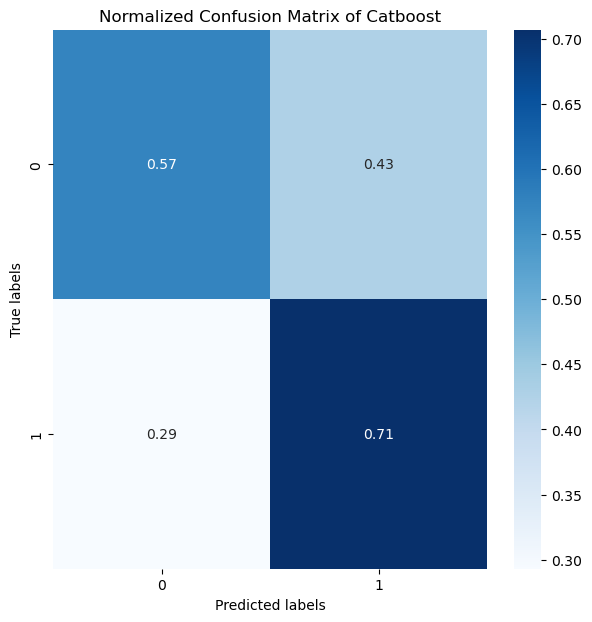

In [80]:
cm(test_X,test_Y,clf_cat,'Catboost',['0','1','2'])
ROC(train_Y,test_Y,test_X,clf_XGB,'Catboost')

In [77]:
def weight(weight):
    new=[]
    for i in range(0,len(test_X)):
        Y=int(weight[0]*y_pred_XGB[i]+weight[1]*y_pred_lgbm[i]+weight[2]*y_pred_cat[i])
        new.append(round(Y,0))
    return new

In [78]:
def Voting():
    new=[]
    for i in range(0,len(test_X)):
        Y=statistics.mode([y_pred_XGB[i],y_pred_lgbm[i],int(y_pred_cat[i])])
        new.append(Y)
    return new

### Final Accuracy

In [79]:
accuracy=accuracy_score(test_Y,Voting())
print("The final accuracy is: ", round(accuracy,4))

The final accuracy is:  0.6725
